![Redis](https://blog.michelletorres.mx/wp-content/uploads/2017/12/Redis_Logo.png)

En este notebook mostramos los pasos correspondientes a la instalación de Redis, la importación de la base de datos de StackOverflow, la resolución de consultas y las pruebas de eficiencia. El resto de apartados se encuentran recogidos en la memoria PDF adjuntada junto al notebook.

# 1. Instalación de la base de datos

Una vez ejecutado el docker-compose.yml, ya tenemos un servidor de Redis instalado. Para poder conectar con Redis desde el notebook, hemos de usar la librería `redis-py` de python. Para instalarla hemos de ejecutar el siguiente comando:

In [2]:
!pip install --upgrade redis

Requirement already up-to-date: redis in /opt/conda/lib/python3.7/site-packages (3.3.11)


Además de cargar `redis-py`, también necesitamos, como en el resto de prácticas entregadas, usar `pandas` y `matplotlib` para mostrar los resultados:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

%matplotlib inline
matplotlib.style.use('ggplot')

A continuación cargamos la librería `redis-py`, y en particular, su función `Redis`, la cual es la clase central del paquete y nos permite ejecutar los comandos de Redis. No tenemos que preocuparnos por la conexión TCP con el socket, ya que se hace automáticamente cuando llamamos a comandos de Redis usando métodos de la instancia que crearemos a continuación. 

In [2]:
import redis
from redis import Redis

Para crear la instancia, llamamos a `Redis` pasándole el nombre del host y el puerto. Por defecto, el puerto que se utiliza para Redis es el 6379. Además, en este comando también podemos indicar qué base de datos queremos elegir, ya que tenemos un total de 16. Al no especificarle ninguna, estamos eligiendo la db 0.

In [3]:
r = Redis(host='redis', port=6379)
r

Redis<ConnectionPool<Connection<host=redis,port=6379,db=0>>>

# 2. Importación de los datos de Stack Overflow

Para obtener los ficheros .csv y guardarlos en el directorio previo al actual, simplemente hemos de hacer lo mismo que en las sesiones vistas en clase: creamos la función `download_csv_upper_dir` y la llamamos sobre cada uno de los .csv.

In [5]:
import os
import os.path as path
from urllib.request import urlretrieve

def download_csv_upper_dir(baseurl, filename):
    file = path.abspath(path.join(os.getcwd(),os.pardir,filename))
    if not os.path.isfile(file):
        urlretrieve(baseurl + '/' + filename, file)
        
baseurl = 'http://neuromancer.inf.um.es:8080/es.stackoverflow/'
download_csv_upper_dir(baseurl, 'Posts.csv')
download_csv_upper_dir(baseurl, 'Users.csv')
download_csv_upper_dir(baseurl, 'Tags.csv')
download_csv_upper_dir(baseurl, 'Comments.csv')
download_csv_upper_dir(baseurl, 'Votes.csv')

Una vez los tenemos, procedemos a leerlos e importarlos en nuestra base de datos Redis. Para ello, vamos a usar *hashes* múltiples. Este tipo de estructura de datos, que explicamos en el archivo PDF adjuntado a la tarea, nos permite añadir diccionarios como valores.

Por tanto, la idea en este caso es añadir un par clave-valor por cada fila de cada tabla de StackOverflow. Los elementos serán por tanto de la forma: 'Users:2000', 'Posts:24', 'Tags:33', etc.

Por otro lado, a la hora de ir añadiendo *hashes*, hemos usado el concepto de *pipelining* de Redis, gracias a la función `pipeline()`. Este nos permite reducir el número de transacciones *round-trip* que necesitamos para escribir o leer datos del servidor. Con un *pipeline*, todos los comandos se almacenan en el cliente y se envían de golpe, usando `pipe.hmset()`, en lugar de `r.hmset()`. Habiendo ejecutado esto último necesitaríamos una operación *round-trip* por cada fila escrita.

In [6]:
import csv
import json
def csv_to_redis(file,tablename):
    with open(file) as f:
        # La llamada csv.reader() crea un iterador sobre un fichero CSV
        reader = csv.reader(f, dialect='excel')

        # Se leen las columnas. Sus nombres se usarán para crear las diferentes columnas en la familia
        columns = next(reader)

        # Usamos un pipeline para que las inserciones en el hash sean más rápidas
        with r.pipeline() as pipe:
            for row in reader:
                pipe.hmset(tablename+":"+row[0],dict(zip(columns[1:], row[1:])))
            pipe.execute()

In [7]:
tables = ['Posts', 'Votes', 'Users', 'Tags', 'Comments']
for t in tables:
    print("Importando tabla {0}...".format(t))
    %time csv_to_redis('..'+t+ '.csv', t)

Importando tabla Posts...
CPU times: user 15.6 s, sys: 255 ms, total: 15.9 s
Wall time: 17.1 s
Importando tabla Votes...
CPU times: user 11 s, sys: 104 ms, total: 11.1 s
Wall time: 11.6 s
Importando tabla Users...
CPU times: user 5.31 s, sys: 40.3 ms, total: 5.35 s
Wall time: 5.54 s
Importando tabla Tags...
CPU times: user 89.9 ms, sys: 53 µs, total: 90 ms
Wall time: 102 ms
Importando tabla Comments...
CPU times: user 9.91 s, sys: 132 ms, total: 10 s
Wall time: 10.3 s


A modo de ejemplo, si quisiéramos obtener el tag 25, simplemente hemos de llamar a la función `hgetall` de nuestra instancia `r`, y obtiene el diccionario que hemos introducido como valor para ese tag. Se puede observar cómo `redis-py` nos devuelve los resultados en forma de bytes, en lugar de strings, tal y como pasaba en HBase.

In [8]:
r.hgetall('Tags:25')

{b'Count': b'55',
 b'ExcerptPostId': b'5008',
 b'TagName': b'socket',
 b'WikiPostId': b'5007'}

# 3. Resolución de las consultas

## EJERCICIO RQ1

Para realizar este ejercicio hemos seguido los siguientes pasos:

- Creamos un hash que lleve la cuenta del número de preguntas de cada usuario. 
- El valor del número de preguntas se inicializa a cero para todos los usuarios, ya que en caso contrario no podríamos contabilizar el número de usuarios que no han hecho preguntas.
- Cada vez que localizamos una pregunta, obtenemos el usuario que la hizo e incrementamos su hash usando la función `hincrby` de Redis. Para realizar el incremento comprobamos que el `Id` del usuario que hace la pregunta no sea vacío.
- Una vez tenemos los hashes con cada una de las cuentas del número de preguntas, recorremos este hash para contar el número de usuarios por cada número de preguntas, usando de nuevo hincrby. En este caso no hay que inicializar a cero el hash porque únicamente estamos interesados en llevar cuenta de aquellas cantidades de preguntas que hayan sido hechas por algún usuario.

Es importante remarcar que usamos la función `scan_iter` para recorrer el hash porque nos permite añadir una expresión regular como parámetro y recorrer únicamente los elementos cuya clave cumpla esa expresión regular. Además, hemos seguido utilizando el concepto de *pipelining* para que la consulta sea más rápida.

El resultado final es un hash llamado `Count_RQ1` que contiene el resultado que queríamos obtener con esta consulta.

In [9]:
%%time
with r.pipeline() as pipe:
    for key in r.scan_iter("Users:*"):
        idUser = key.decode('utf-8').split(":")[1]
        pipe.hset('Count:'+idUser,'value',0)
    pipe.execute()
    
    for key in r.scan_iter("Posts:*"):
        if (r.hmget(key,b'PostTypeId')[0].decode('utf-8') == '1'):
            ownerUserId = r.hmget(key,b'OwnerUserId')[0].decode('utf-8')
            if ownerUserId != "":
                pipe.hincrby('Count:'+ownerUserId,'value',1)
    pipe.execute()
    
    for key in r.scan_iter("Count:*"):
        count = r.hmget(key,b'value')[0].decode('utf-8')
        pipe.hincrby('CountRQ1',count,1)
    pipe.execute()

CPU times: user 23.9 s, sys: 5.52 s, total: 29.5 s
Wall time: 33.4 s


Para obtener el número de usuarios por cada número de preguntas, hemos de ejecutar:

In [10]:
r.hgetall('CountRQ1')

{b'0': b'38094',
 b'2': b'1603',
 b'1': b'6840',
 b'6': b'184',
 b'5': b'295',
 b'11': b'49',
 b'15': b'35',
 b'3': b'706',
 b'10': b'79',
 b'83': b'2',
 b'12': b'43',
 b'9': b'76',
 b'8': b'105',
 b'7': b'142',
 b'4': b'407',
 b'14': b'37',
 b'33': b'3',
 b'23': b'9',
 b'24': b'16',
 b'39': b'4',
 b'30': b'9',
 b'21': b'15',
 b'16': b'24',
 b'25': b'10',
 b'27': b'5',
 b'79': b'1',
 b'20': b'20',
 b'19': b'19',
 b'36': b'3',
 b'115': b'1',
 b'42': b'1',
 b'17': b'20',
 b'44': b'2',
 b'22': b'16',
 b'38': b'2',
 b'45': b'3',
 b'75': b'1',
 b'31': b'4',
 b'107': b'1',
 b'18': b'13',
 b'49': b'2',
 b'29': b'11',
 b'26': b'12',
 b'50': b'4',
 b'130': b'1',
 b'37': b'6',
 b'28': b'6',
 b'13': b'34',
 b'64': b'2',
 b'35': b'4',
 b'96': b'1',
 b'62': b'2',
 b'47': b'4',
 b'71': b'1',
 b'55': b'2',
 b'32': b'4',
 b'46': b'3',
 b'48': b'5',
 b'43': b'4',
 b'72': b'1',
 b'51': b'3',
 b'41': b'3',
 b'84': b'1',
 b'95': b'1',
 b'223': b'1',
 b'60': b'1',
 b'119': b'2',
 b'114': b'1',
 b'158': b'1

Una vez llegados a este punto, viendo que la consulta no es todo lo rápida que podría ser, nos preguntamos si existe una mejor forma de redistribuir los datos de StackOverflow. Lo que hemos hecho consiste en tener tantos hashes como filas hay en cada tabla, conteniendo únicamente como valor el diccionario que hace referencia a los valores de cada fila.

En lugar de tener tantos hashes y realizar por tanto tantas iteraciones a la hora de recorrerlos, podríamos tener simplemente un hash por cada tabla. Sin embargo, surge la pregunta de cómo añadir diccionarios anidados a cada hash. Redis no soporta esta operación directamente. Por tanto, hemos de encontrar una manera de representar los datos para que Redis los acepte. La solución encontrada ha sido realizar una serialización de los diccionarios anidados convirtiéndolos a un string, usando la librería `json` de `python`, junto con el uso de la función `hset` de redis, que nos permite ir creando pares clave-valor asociados a cada hash.

Tras realizar varias pruebas hemos comprobado que las consultas se realizan más rápidamente, por lo que vamos a limpiar la base de datos y a importarlos de nuevo de esta forma.

Limpiamos la base de datos:

In [11]:
r.flushdb()

True

A continuación creamos una nueva función que construye los hashes indicados arriba. En este caso, en lugar de usar `hmset`, como también hemos indicado, usamos la función `hset`, ya que no necesitamos añadir un diccionario como valor, sino que necesitamos ir añadiendo pares clave-valor, donde cada clave es el string devuelto por la función `dumps` de `json` sobre el diccionario correspondiente a cada fila.

In [12]:
def csv_to_redis2(file,tablename):
    with open(file) as f:
        # La llamada csv.reader() crea un iterador sobre un fichero CSV
        reader = csv.reader(f, dialect='excel')

        # Se leen las columnas. Sus nombres se usarán para crear las diferentes columnas en la familia
        columns = next(reader)
        
        # Usamos un pipeline para que las inserciones en el hash sean más rápidas
        with r.pipeline() as pipe:
            for row in reader:
                pipe.hset(tablename,tablename+':'+row[0],json.dumps(dict(zip(columns[1:], row[1:]))))
            pipe.execute()

In [13]:
tables = ['Posts', 'Votes', 'Users', 'Tags', 'Comments']
for t in tables:
    print("Importando tabla {0}...".format(t))
    %time csv_to_redis2('..'+t+ '.csv', t)

Importando tabla Posts...
CPU times: user 8.43 s, sys: 189 ms, total: 8.62 s
Wall time: 8.97 s
Importando tabla Votes...
CPU times: user 6.5 s, sys: 44.7 ms, total: 6.54 s
Wall time: 6.76 s
Importando tabla Users...
CPU times: user 2.79 s, sys: 31.9 ms, total: 2.82 s
Wall time: 2.86 s
Importando tabla Tags...
CPU times: user 50.4 ms, sys: 0 ns, total: 50.4 ms
Wall time: 50.4 ms
Importando tabla Comments...
CPU times: user 5.74 s, sys: 79.4 ms, total: 5.82 s
Wall time: 6 s


El proceso para resolver la consulta RQ1 es el mismo que hemos seguido arriba, a diferencia de que ahora usamos `hscan_iter` para recorrer, ya que no necesitamos añadir una expresión regular como parámetro y simplemente queremos recorrer los hashes correspondientes a una tabla concreta. La función `hscan_iter` es especifica de los hashes.

In [18]:
%%time
with r.pipeline() as pipe:
    for key in r.hscan_iter("Users"):
        idUser = key[0].decode('utf-8').split(":")[1]
        pipe.hset('Count_aux1','value:'+idUser,0)
    pipe.execute()
    
    for key in r.hscan_iter("Posts"):
        if (json.loads(key[1].decode('utf-8'))['PostTypeId'] == '1'):
            ownerUserId = json.loads(key[1].decode('utf-8'))['OwnerUserId']
            if ownerUserId != "":
                pipe.hincrby('Count_aux1','value:'+ownerUserId,1)
    pipe.execute()
    
    for key in r.hscan_iter("Count_aux1"):
        pipe.hincrby('CountRQ1',key[1],1)
    pipe.execute()

CPU times: user 9.25 s, sys: 428 ms, total: 9.68 s
Wall time: 10.8 s


Podemos observar que la consulta ha sido entorno al triple de rápida que la anterior RQ1. A continuación construimos un diccionario con los valores devueltos por el hash construido y creamos un dataframe que nos permite mostrarlos en forma de histograma:

In [19]:
d = r.hgetall('CountRQ1')
d = {int(k.decode('utf8')): int(v.decode('utf8')) for k, v in d.items()}
questions_df = pd.DataFrame(list(d.items()),columns=['Question_number','Count'])
questions_df = questions_df.sort_values(by = 'Question_number')
questions_df.index = range(1, len(questions_df)+1)
questions_df

,Question_number,Count
1,0,38094
2,1,6840
3,2,1603
4,3,706
5,4,407
...,...,...
74,119,2
75,130,1
76,144,1
77,158,1


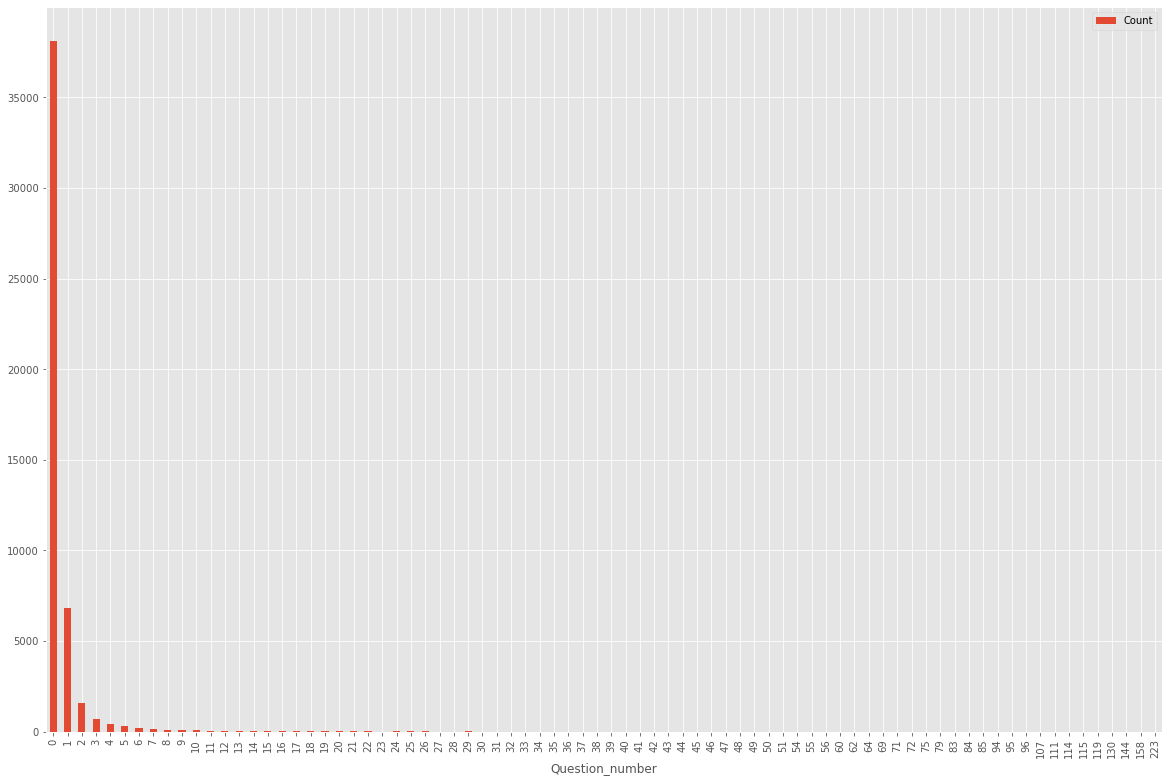

In [20]:
questions_df.plot(x='Question_number', y='Count', kind='bar', figsize=(20,20*2/3))

# EJERCICIO RQ2

El proceso para realizar este ejercicio es el mismo que se ha indicado para la consulta RQ1:

In [21]:
%%time
with r.pipeline() as pipe:
    for key in r.hscan_iter("Users"):
        idUser = key[0].decode('utf-8').split(":")[1]
        pipe.hset('Count_aux2','value:'+idUser,0)
    pipe.execute()
    
    for key in r.hscan_iter("Posts"):
        if (json.loads(key[1].decode('utf-8'))['PostTypeId'] == '2'):
            ownerUserId = json.loads(key[1].decode('utf-8'))['OwnerUserId']
            if ownerUserId != "":
                pipe.hincrby('Count_aux2','value:'+ownerUserId,1)
    pipe.execute()
    
    for key in r.hscan_iter("Count_aux2"):
        pipe.hincrby('CountRQ2',key[1],1)
    pipe.execute()

CPU times: user 10.5 s, sys: 299 ms, total: 10.8 s
Wall time: 11.6 s


In [22]:
d = r.hgetall('CountRQ2')
d = {int(k.decode('utf8')): int(v.decode('utf8')) for k, v in d.items()}
answers_df = pd.DataFrame(list(d.items()),columns=['Answer_number','Count'])
answers_df = answers_df.sort_values(by = 'Answer_number')
answers_df.index = range(1, len(answers_df)+1)
answers_df

,Answer_number,Count
1,0,42769
2,1,3358
3,2,998
4,3,450
5,4,263
...,...,...
132,469,1
133,542,1
134,669,1
135,729,1


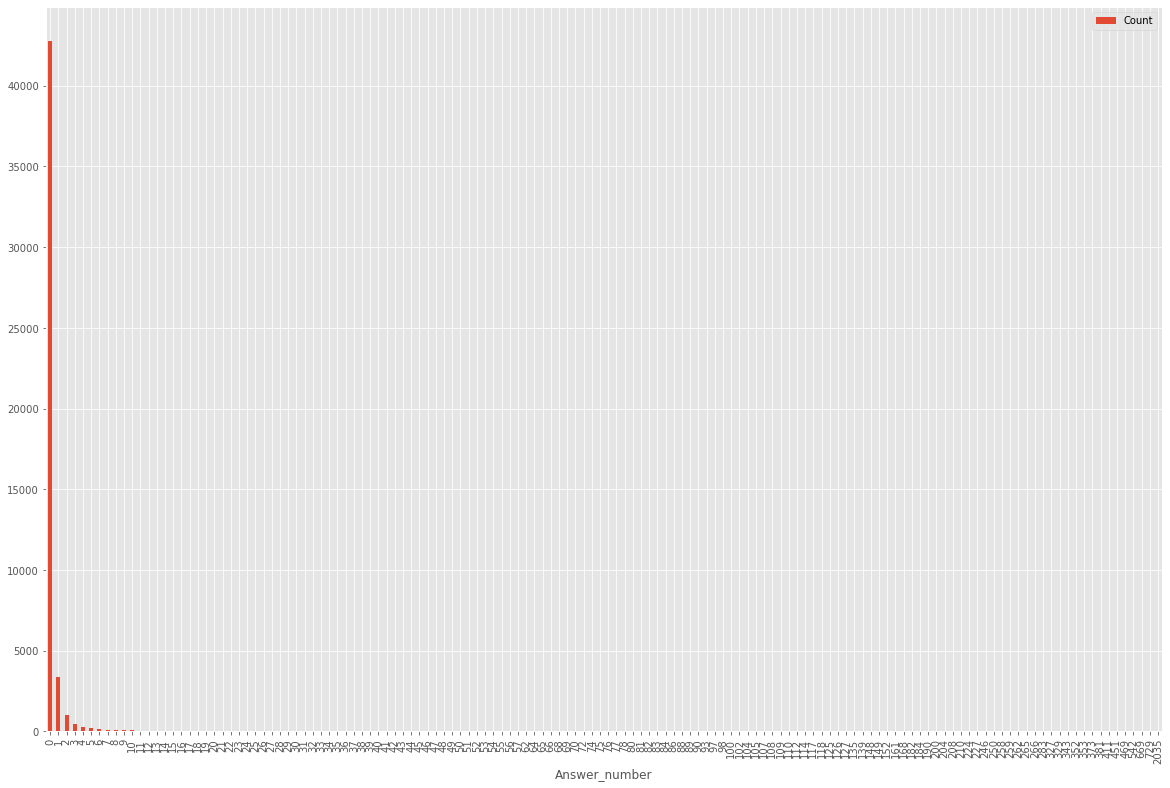

In [23]:
answers_df.plot(x='Answer_number', y='Count', kind='bar', figsize=(20,20*2/3))

# EJERCICIO RQ3

Para resolver esta consulta seguimos el siguiente procedimiento:

- Recorremos los posts y creamos dos hashes: percentages y num. Estos dos hashes tienen el cometido de guardar el porcentaje de posts que son respuestas de cada usuario y el número de posts que ha publicado, respectivamente.
- Cuando leemos un post, ya sea pregunta o respuesta, pueden pasar dos cosas: que el usuario *owner* del post ya tenga un par clave-valor asociado en los hashes, o que no. En caso de que no existan sus hashes, se crean y se añade 0 al porcentaje si es una pregunta, o 100 si es una respuesta. Por otro lado, se establece como 1 el número de posts de ese usuario.
- Una vez vamos leyendo posts de usuarios que sí tienen un par clave-valor en cada hash, hemos de actualizar el porcentaje usando el número de posts que hemos ido guardando. Este porcentaje se actualiza multiplicando el porcentaje anterior por el número de posts y sumándole el nuevo porcentaje (0 o 100). El resultado se divide por el número de posts del usuario más 1, y ya tenemos el nuevo porcentaje.
- Cuando acabamos de rellenar ambos hashes, simplemente tenemos que recorrer los porcentajes y contar cuántos de ellos pertenecen a cada uno de los grupos especificados en el paper para la RQ3, lo que nos devuelve un hash final cuyo nombre es `RQ3`. 

Es importante remarcar que en esta consulta no hemos utilizado *pipelining* ya que, al mandarse todas las consultas a la vez, y depender esas consultas de condiciones lógicas de existencia de los hashes, como unas dependen de la ejecución de otras, no tienen por qué realizarse en el orden que queremos. El no usar *pipelines* influye en el hecho de que esta sea la consulta más lenta de las cuatro.

In [24]:
%%time
for key in r.hscan_iter("Posts"):
    postTypeId = json.loads(key[1].decode('utf-8'))['PostTypeId']
    if (postTypeId == '1'):
        ownerUserId = json.loads(key[1].decode('utf-8'))['OwnerUserId'] 
        percentage = 0
    elif (postTypeId == '2'):
        ownerUserId = json.loads(key[1].decode('utf-8'))['OwnerUserId'] 
        percentage = 100
    else:
        continue
    if  not r.hexists('percentage','user:'+ownerUserId):
        r.hset('percentage', 'user:'+ownerUserId, percentage)
        r.hset('num','user:'+ownerUserId, 1)
    else:
        perc = float(r.hget('percentage','user:'+ownerUserId).decode('utf-8'))
        num = int(r.hget('num','user:'+ownerUserId).decode('utf-8'))
        new_perc = (perc*num + percentage)/(num+1)
        r.hset('percentage', 'user:'+ownerUserId, new_perc)
        r.hincrby('num','user:'+ownerUserId, 1)

for key in r.hscan_iter("percentage"):
    percentage = float(key[1].decode('utf-8'))
    case = lambda x: percentage < x
    if percentage == 0.0:
        r.hincrby('RQ3','0%',1)
    elif case(10.0):
        r.hincrby('RQ3','1-9%',1)
    elif case(20.0):
        r.hincrby('RQ3','10-19%',1)
    elif case(30.0):
        r.hincrby('RQ3','20-29%',1)
    elif case(40.0):
        r.hincrby('RQ3','30-39%',1)
    elif case(50.0):
        r.hincrby('RQ3','40-49%',1)
    elif case(60.0):
        r.hincrby('RQ3','50-59%',1)
    elif case(70.0):
        r.hincrby('RQ3','60-69%',1)
    elif case(80.0):
        r.hincrby('RQ3','70-79%',1)
    elif case(90.0):
        r.hincrby('RQ3','80-89%',1)
    elif case(100.0):
        r.hincrby('RQ3','90-99%',1)
    elif percentage == 100.0:
        r.hincrby('RQ3','100%',1)

CPU times: user 28 s, sys: 7.76 s, total: 35.8 s
Wall time: 40.7 s


In [25]:
r.hgetall('RQ3')

{b'100%': b'3564',
 b'0%': b'8239',
 b'20-29%': b'373',
 b'30-39%': b'368',
 b'50-59%': b'774',
 b'60-69%': b'223',
 b'40-49%': b'118',
 b'1-9%': b'124',
 b'10-19%': b'263',
 b'90-99%': b'142',
 b'80-89%': b'164',
 b'70-79%': b'152'}

Creamos un diccionario asociado al hash anterior y lo ordenamos. Después lo pasamos a dataframe para mostrarlo como histgrama.

In [26]:
d = r.hgetall('RQ3')
d = {k.decode('utf8'): int(v.decode('utf8')) for k, v in sorted(d.items(),key=lambda x: int(x[0][:-1].decode('utf-8').split('-')[0]))}
df = pd.DataFrame(list(d.items()), columns = ['Percentages', 'Count'])
df

,Percentages,Count
0,0%,8239
1,1-9%,124
2,10-19%,263
3,20-29%,373
4,30-39%,368
5,40-49%,118
6,50-59%,774
7,60-69%,223
8,70-79%,152
9,80-89%,164


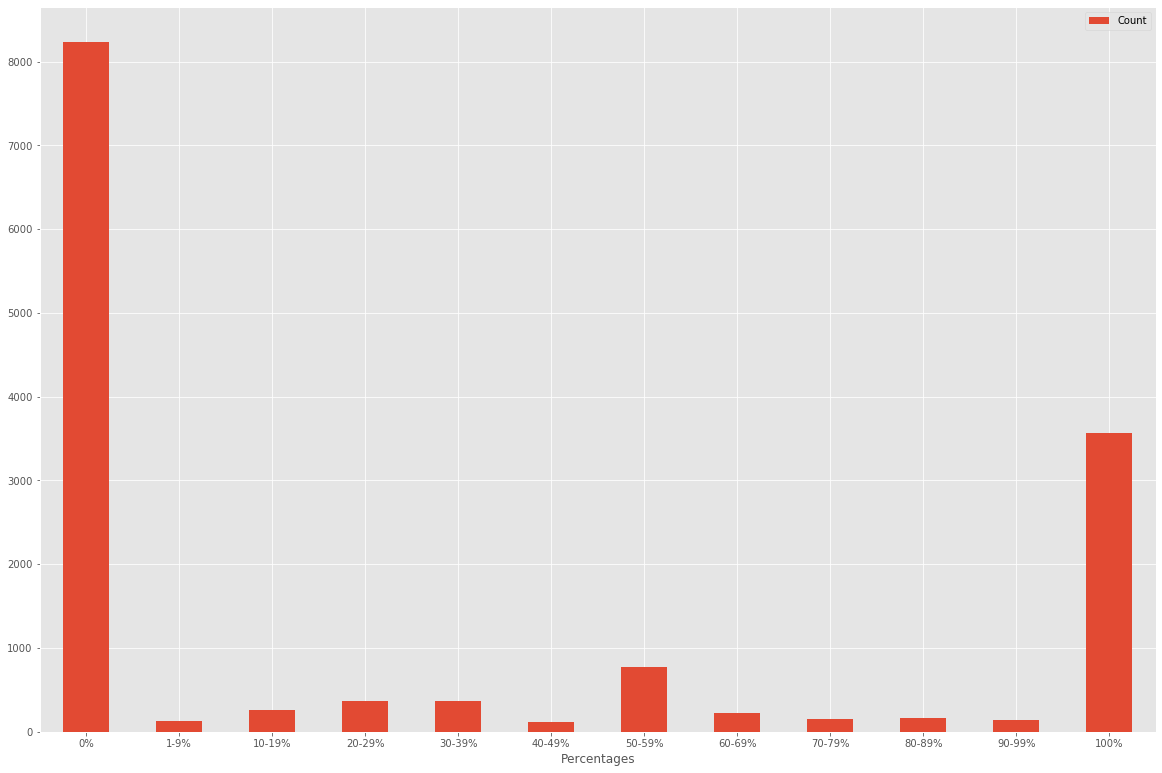

In [27]:
df.plot(x='Percentages', y='Count', kind='bar', figsize=(20,20*2/3), rot=0)

# EJERCICIO RQ4

En este ejercicio vamos a combinar el uso de hashes con el uso de listas. A continuación mostramos el proceso seguido y por qué usamos listas además de hashes:

- Comenzamos iterando sobre los posts y, para cada respuesta, creamos una serie de hashes que contienen, como nombre, el `Id` del usuario que pregunta, y como par clave/valor hemos repetido el `Id` del usuario que responde. Si hubiéramos usado listas o sets en este paso, cada vez que añadiéramos un elemento a un hash de un usuario concreto, se sobreescribiría el usuario que responde, por lo que hemos decidido tener un hash por cada usuario que pregunta e ir añadiéndole pares clave-valor que hacen referencia al que responde.
- Para ir añadiendo elementos a cada hash, hemos de comprobar primero que el `Id` del usuario que pregunta no sea igual al del que responde y que ambos identificadores no sean vacíos.
- Una vez tenemos estos nuevos hashes, cuyos nombres empiezan todos por `Users_QA:`, los recorremos usando `scan_iter` y una sencilla expresión regular y, por cada usuario que ha respondido al que forma parte del nombre del hash, comprobamos:
    - Si el usuario que pregunta también ha contestado al usuario que responde, como probando si el que pregunta está entre los valores del hash correspondiente al que responde. 
    - Que el id del usuario que pregunta sea menor que el que responde. De esta manera evitamos duplicados.
- Si se verifican estas condiciones, añadimos un elemento a una lista llamada `RQ4`. El motivo de usar una lista se debe a que, si usáramos un hash con nombre `RQ4`, con clave el usuario que pregunta y con valor el que responde, este hash se sobreescribiría cada vez que añadiéramos un nuevo valor a una clave que ya existe. Por tanto, hemos decidido concatenar ambos usuarios y añadirlos a una lista. También se ha probado a usar Sets, y se ha visto que el tiempo de ejecución de ambas queries es muy similar, siendo el de las listas ligeramente inferior.

In [32]:
%%time
with r.pipeline() as pipe:
    for key in r.hscan_iter("Posts"):
        row = json.loads(key[1].decode('utf-8'))
        if (row['PostTypeId'] == '2'):
            ownerUserId = row['OwnerUserId']
            parentId = row['ParentId']
            questioner = json.loads(r.hget('Posts','Posts:'+parentId).decode('utf-8'))['OwnerUserId']
            if questioner != ownerUserId and questioner != "" and ownerUserId != "":
                pipe.hset('Users_QA:'+questioner,'key:'+ownerUserId,ownerUserId)
    pipe.execute()
    
    for name in r.scan_iter("Users_QA:*"):
        for value in r.hgetall(name).values():
            user1 = name.decode('utf-8').split(':')[1]
            user2 = value.decode('utf-8')
            if (int(user1) < int(user2) and user1.encode('utf-8') in r.hgetall("Users_QA:"+user2).values()):
                pipe.lpush('RQ4', user1 + ' - ' + user2)
    pipe.execute()

CPU times: user 10.8 s, sys: 1.47 s, total: 12.3 s
Wall time: 14.2 s


A continuación podemos observar el número de elementos de la lista y todos los usuarios que son recíprocos ordenados por el primer usuario:

In [29]:
print(r.llen('RQ4'))
sorted(r.lrange('RQ4',0,r.llen('RQ4')), key = lambda x: (int(x.decode('utf-8').split(' - ')[0]), int(x.decode('utf-8').split(' - ')[1])))

116


[b'21 - 1184',
 b'22 - 288',
 b'22 - 342',
 b'22 - 729',
 b'23 - 25',
 b'24 - 25',
 b'24 - 95',
 b'24 - 301',
 b'24 - 463',
 b'24 - 2230',
 b'24 - 19610',
 b'25 - 225',
 b'25 - 288',
 b'34 - 250',
 b'65 - 78',
 b'65 - 1184',
 b'65 - 7661',
 b'65 - 13558',
 b'73 - 250',
 b'73 - 2224',
 b'73 - 6497',
 b'73 - 9897',
 b'73 - 29967',
 b'78 - 250',
 b'83 - 100',
 b'83 - 301',
 b'83 - 29967',
 b'95 - 29967',
 b'100 - 187',
 b'100 - 353',
 b'100 - 399',
 b'100 - 529',
 b'100 - 638',
 b'100 - 729',
 b'100 - 2004',
 b'100 - 2838',
 b'120 - 531',
 b'154 - 13938',
 b'191 - 2230',
 b'227 - 342',
 b'227 - 400',
 b'227 - 2004',
 b'250 - 399',
 b'250 - 729',
 b'250 - 731',
 b'250 - 2163',
 b'250 - 2230',
 b'250 - 2429',
 b'250 - 6491',
 b'250 - 9897',
 b'250 - 10576',
 b'250 - 12625',
 b'250 - 13558',
 b'250 - 13938',
 b'250 - 14243',
 b'250 - 18597',
 b'250 - 19610',
 b'250 - 27881',
 b'250 - 29967',
 b'301 - 2230',
 b'342 - 517',
 b'342 - 2367',
 b'398 - 547',
 b'398 - 2171',
 b'399 - 555',
 b'463 -

# 4. Pruebas de eficiencia

En este apartado vamos a realizar cuatro pruebas de eficiencia entre Redis y el resto de bases de datos vistas en la asignatura, y vamos a mostrar el tiempo de ejecución de las mismas usando histogramas. Las pruebas que vamos a realizar son:

- Consulta RQ4.
- Consulta RQ3: en este caso compararemos únicamente las bases de datos con las que hemos ejecutado esta consulta (SQL, Mongo y Redis).
- Acceso por clave a un determinado elemento de la base de datos.
- Tiempo de carga de la tabla Posts. Se usa solo el de Posts porque las diferencias en los tiempos del resto de cargas son proporcionales a las que vamos a ver en este histograma.

Los tiempos para Redis los hemos ido midiendo conforme hacíamos el notebook, mientras que los otros los hemos medido en los notebooks correspondientes. Para medir el acceso por clave en Redis hacemos:

In [41]:
%timeit r.hmget("Posts", "Posts:25")

86.4 µs ± 26.9 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


A continuación se muestra cada uno de los histogramas mencionados. En el primero de ellos, correspondiente a la consulta RQ4, podemos obsevar que HBase es el más lento de todos, ya que para su ejecución creamos una tabla intermedia y el proceso era más largo. La más rápida es Mongo, mientras que Redis no da un tiempo excesivamente alto pero se ve superada por SQL, Mongo y Neo4j.

![](Hist_RQ4.png)

En la siguiente figura vemos cómo Redis tarda mucho más en realizar la RQ3 que Mongo y SQL, siendo esta última la más rápida.

![](Hist_RQ3.png)

Para el histograma de acceso por clave, hemos tenido que poner escala logarítmica en el eje Y, debido a los resultados dispares que hemos obtenido. Se puede apreciar que, exceptuando a Mongo, Redis es más rápida que las demás en esta tarea.

![](HistAccesoClave.png)

Por último, en lo que respecta a la carga de los CSV en las diferentes bases de datos, volvemos a ver cómo Redis mejora a la mayoría, viéndose únicamente superada por SQL.

![](HistCarga.png)